In [1]:
import torch
import torch.nn as nn
import pickle as pk
import numpy as np
from model import LocalPredictor
import random

In [2]:
data = dict({})
for d in range(1, 29):
    filename = '/data/fan/UsersInOsakaProcessed/201210{:02d}_interp.pk'.format(d)
    print(filename)
    with open(filename, 'rb') as f:
        data[d] = pk.load(f)

/data/fan/UsersInOsakaProcessed/20121001_interp.pk
/data/fan/UsersInOsakaProcessed/20121002_interp.pk
/data/fan/UsersInOsakaProcessed/20121003_interp.pk
/data/fan/UsersInOsakaProcessed/20121004_interp.pk
/data/fan/UsersInOsakaProcessed/20121005_interp.pk
/data/fan/UsersInOsakaProcessed/20121006_interp.pk
/data/fan/UsersInOsakaProcessed/20121007_interp.pk
/data/fan/UsersInOsakaProcessed/20121008_interp.pk
/data/fan/UsersInOsakaProcessed/20121009_interp.pk
/data/fan/UsersInOsakaProcessed/20121010_interp.pk
/data/fan/UsersInOsakaProcessed/20121011_interp.pk
/data/fan/UsersInOsakaProcessed/20121012_interp.pk
/data/fan/UsersInOsakaProcessed/20121013_interp.pk
/data/fan/UsersInOsakaProcessed/20121014_interp.pk
/data/fan/UsersInOsakaProcessed/20121015_interp.pk
/data/fan/UsersInOsakaProcessed/20121016_interp.pk
/data/fan/UsersInOsakaProcessed/20121017_interp.pk
/data/fan/UsersInOsakaProcessed/20121018_interp.pk
/data/fan/UsersInOsakaProcessed/20121019_interp.pk
/data/fan/UsersInOsakaProcessed

In [3]:
uid_sets = dict({})
for d in data:
    uid_sets[d] = set(list(data[d].keys()))

In [4]:
uid_doc_set = set([])
for d in range(1, 15):
    uid_doc_set = uid_doc_set | uid_sets[d]

In [5]:
data_doc = dict({})
data_qry_train = dict({})
data_qry_test = dict({})

for d in range(1, 15):
    for uid in data[d]:
        if uid not in data_doc:
            data_doc[uid] = [data[d][uid]]
        else:
            data_doc[uid].append(data[d][uid])

for d in range(15, 22):
    for uid in data[d]:
        if uid not in data_qry_train:
            data_qry_train[uid] = [data[d][uid]]
        else:
            data_qry_train[uid].append(data[d][uid])
            
for d in range(22, 29):
    for uid in data[d]:
        if uid not in data_qry_test:
            data_qry_test[uid] = [data[d][uid]]
        else:
            data_qry_test[uid].append(data[d][uid])

In [6]:
for uid in data_doc:
    data_doc[uid] = torch.LongTensor(data_doc[uid]).cuda(1)

for uid in data_qry_train:
    data_qry_train[uid] = torch.LongTensor(data_qry_train[uid]).cuda(1)
    
for uid in data_qry_test:
    data_qry_test[uid] = torch.LongTensor(data_qry_test[uid]).cuda(1)

In [18]:
num_locs = 1600
loc_embedding_dim = 128
T = 96
num_time = T
time_embedding_dim = 32
hidden_dim = 256
latent_dim = 256
n_layers = 2

In [19]:
dT = 4

In [20]:
training_loss = dict({})
validation_loss = dict({})

In [31]:
batch_size = 128
user_list_train = list(data_qry_train.keys())

for perc in [1]:
    
    print('')
    print('Percentage ', perc)
    
    local_predictor = LocalPredictor(num_locs, loc_embedding_dim, num_time, time_embedding_dim, hidden_dim, latent_dim, n_layers).cuda(1)

    optimizer = torch.optim.RMSprop(local_predictor.parameters(), lr=1e-3)
    
    user_list_train_subset = random.sample(user_list_train, int(len(user_list_train) * perc * 0.01))

    for epoch in range(1, 41):
        optimizer.zero_grad()

        random.shuffle(user_list_train_subset)

        avg_loss = 0.0
        cnt = 0

        for uid in user_list_train_subset:
            t = np.random.randint(T - 2 * dT + 1)
            x_loc_qry = data_qry_train[uid][:, t: t + dT]
            x_t_qry = torch.zeros_like(x_loc_qry) + t
            y = data_qry_train[uid][:, t + 2 * dT - 1]

            if uid not in data_doc:
                loss = local_predictor(x_loc_qry, x_t_qry, None, None, y)
            else:
                x_loc_doc = []
                x_t_doc = []
                for j in range(0, 1):
                    if t + j >= 0 and t + 2 * dT + j <= T:
                        tmp = data_doc[uid][:, t + j: t + 2 * dT + j]
                        x_loc_doc.append(tmp)
                        x_t_doc.append(torch.zeros_like(tmp) + t + j)
                loss = local_predictor(x_loc_qry, x_t_qry, torch.cat(x_loc_doc, dim=0), torch.cat(x_t_doc, dim=0), y)

            loss.backward()
            cnt += data_qry_train[uid].shape[0]
            avg_loss += loss.item()

            if cnt % batch_size == 0:
                optimizer.step()
                optimizer.zero_grad()
        
        print('Training Loss = {:.4f}'.format(avg_loss / cnt))

        # testing
        cnt = 0
        avg_loss = 0.0

        with torch.no_grad():
            for uid in data_qry_test:
                t = np.random.randint(T - 2 * dT + 1)
                x_loc_qry = data_qry_test[uid][:, t: t + dT]
                x_t_qry = torch.zeros_like(x_loc_qry) + t
                y = data_qry_test[uid][:, t + 2 * dT - 1]

                if uid not in data_doc:
                    loss = local_predictor(x_loc_qry, x_t_qry, None, None, y)
                else:
                    x_loc_doc = []
                    x_t_doc = []
                    for j in range(0, 1):
                        if t + j >= 0 and t + 2 * dT + j <= T:
                            tmp = data_doc[uid][:, t + j: t + 2 * dT + j]
                            x_loc_doc.append(tmp)
                            x_t_doc.append(torch.zeros_like(tmp) + t + j)
                    loss = local_predictor(x_loc_qry, x_t_qry, torch.cat(x_loc_doc, dim=0), torch.cat(x_t_doc, dim=0), y)

                cnt += data_qry_test[uid].shape[0]
                avg_loss += loss.item()

        print('Validation Loss = {:.4f}'.format(avg_loss / cnt))
        
        if (perc in validation_loss) and validation_loss[perc] > avg_loss / cnt:
            validation_loss[perc] = avg_loss / cnt


Percentage  1
Training Loss = 7.2222
Validation Loss = 6.9738
Training Loss = 6.2548
Validation Loss = 6.6086
Training Loss = 5.4910
Validation Loss = 6.2876
Training Loss = 4.6057
Validation Loss = 5.9137
Training Loss = 3.8324
Validation Loss = 5.6958
Training Loss = 3.4515
Validation Loss = 5.3949
Training Loss = 3.1160
Validation Loss = 5.2802
Training Loss = 2.8846
Validation Loss = 5.0927
Training Loss = 2.7535
Validation Loss = 4.9916
Training Loss = 2.6819
Validation Loss = 4.9063
Training Loss = 2.4553
Validation Loss = 4.8356
Training Loss = 2.3888
Validation Loss = 4.7593
Training Loss = 2.3865
Validation Loss = 4.7338
Training Loss = 2.1370
Validation Loss = 4.7111
Training Loss = 2.1458
Validation Loss = 4.6682
Training Loss = 2.1853
Validation Loss = 4.6218
Training Loss = 2.1030
Validation Loss = 4.5701
Training Loss = 2.0235
Validation Loss = 4.5573
Training Loss = 2.0180
Validation Loss = 4.5087
Training Loss = 1.9688
Validation Loss = 4.4657
Training Loss = 1.9077
Va

KeyboardInterrupt: 

In [25]:
import matplotlib.pyplot as plt

In [34]:
valid_loss = [4.2689, 2.3209, 1.9107, 1.4396, 1.3933]

Text(0.5, 1.0, 'Osaka')

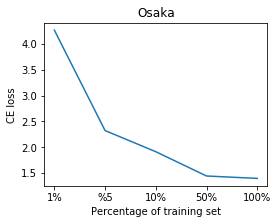

In [35]:
plt.figure(figsize=(4, 3))
plt.plot(valid_loss)
plt.xticks(np.linspace(0, 4, 5), labels=['1%', '%5', '10%', '50%', '100%'])
plt.xlabel('Percentage of training set')
plt.ylabel('CE loss')
plt.title('Osaka')